### Preliminaries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
from torch import nn 
import torch.nn.functional as F
from torch import optim
from torch.autograd import grad

from argparse import Namespace
from functools import reduce
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/229 Project'

Mounted at /content/drive
/content/drive/My Drive/229 Project


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DeepXDE

In [ ]:
# install deepxde
%pip install deepxde

# import packages

from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("tensorflow.compat.v1")

import deepxde as dde

import numpy as np

import torch

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.7 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# define the PDE

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [ ]:
# define a computational geometry and a time domain

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# define the boundary and initial conditions

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [ ]:
# define the time PDE problem

data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=25400, num_boundary=80, num_initial=160)

In [ ]:
# choose the network architecture and the training method

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])

Compiling model...
Building feed-forward neural network...
'build' took 0.053160 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 10.062381 s



### Fourier Analysis

#### Fourier Helper Functions

In [ ]:
def get_fft(y, sampling_rate):
  # Calculate the Fourier transform of f(x)
  fourier = np.fft.fft(y.squeeze())

  length = len(y)

  # Calculate the corresponding frequencies
  freq = np.fft.fftfreq(length, 1/sampling_rate)

  results = list(zip(freq, np.abs(fourier)))
  filtered = [(x, y) for (x, y) in results if x > 0]
  results = list(zip(*filtered))


  return results

In [ ]:
def compare_solutions(t, y_true, y_pred, domain_len):
  start = round(256 * t * 100)
  end = start + 256

  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 5))

  ax0.plot(X[:, 0][start:end], y_true[start:end], "b-", label="Exact", linewidth=3)
  ax0.plot(X[:, 0][start:end], y_pred[start:end], "r--", label="Prediction", linewidth=3)
  ax0.legend(fontsize=12)
  ax0.set_title(f"Comparing Solutions at Time {t}")
  ax0.set_xlabel("x")
  ax0.set_ylabel("u(x, t)")

  true_freq, true_fourier = get_fft(y_true[start:end], 256/domain_len)
  pred_freq, pred_fourier = get_fft(y_pred[start:end], 256/domain_len)
  ax1.plot(true_freq, true_fourier, "b-", label="Exact", linewidth=3)
  ax1.plot(pred_freq, pred_fourier, "r--", label="Prediction", linewidth=3)
  ax1.legend(fontsize=12)
  ax1.set_title(f"Comparing Fourier Transforms of Solutions at Time {t}")
  ax1.set_xlabel("Frequency")
  ax1.set_ylabel("Amplitude")

  fourier_diff = abs(np.array(true_fourier) - np.array(pred_fourier))
  ax2.plot(true_freq, fourier_diff, "b-", linewidth=3)
  ax2.set_title(f"Difference in Fourier Transforms of Solutions at Time {t}")
  ax2.set_xlabel("Frequency")
  ax2.set_ylabel("Absolute Difference in Amplitude")
  
  plt.show()

In [ ]:
import pandas as pd
from matplotlib.colors import LogNorm, Normalize

def plot_spectral_dynamics(all_preds, y_true, t):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    start = round(256 * t * 100)
    end = start + 256
    true_freq, true_fourier = get_fft(y_true[start:end], 256/2)

    pct_dict = {"iter": [], "freq": [], "value": []}
    error_dict = {"iter": [], "freq": [], "value": []}
    
    # Compute spectra for all frames
    for iter, pred in all_preds.items(): 
        if iter % 1000 == 0 or iter == 500:
          pred_freq, pred_fourier = get_fft(pred[start:end], 256/2)
          pct_diff = abs(np.array(pred_fourier) - np.array(true_fourier))/np.array(true_fourier) * 100
          abs_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

          for idx, freq in enumerate(pred_freq):
            pct_dict["iter"].append(iter)
            pct_dict['freq'].append(freq)
            pct_dict['value'].append(pct_diff[idx])

            error_dict["iter"].append(iter)
            error_dict['freq'].append(freq)
            error_dict['value'].append(abs_diff[idx])


    pct_diffs = pd.DataFrame(data = pct_dict)
    pct_diffs = pct_diffs.round(3)
    pct_diffs = pct_diffs.pivot("iter", "freq", "value")
    sns.heatmap(pct_diffs, yticklabels=3, xticklabels=10, vmin=0., vmax=100, cbar_kws={'label': 'Percentage Error in Amplitude'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Frequency")
    ax0.set_ylabel("Training Iteration")
    ax0.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")


    abs_diffs = pd.DataFrame(data = error_dict)
    abs_diffs = abs_diffs.round(3)
    abs_diffs = abs_diffs.pivot("iter", "freq", "value")
    sns.heatmap(abs_diffs, yticklabels=3, xticklabels=10, vmin=0., vmax=max(error_dict['value']), cbar_kws={'label': 'Absolute Error in Amplitude'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("Frequency")
    ax1.set_ylabel("Training Iteration")
    ax1.set_title(f"Frequency Dynamics of Predicted Solution at t = {t}")

    plt.show()

In [ ]:
def plot_l2_errors(preds, y_true, iteration, domain_len):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 8))

    freq_dict = {"time": [], "freq": [], "value": []}
    x_dict = {"time": [], "x": [], "value": []}

    for t in np.linspace(0, 0.99, 100):
      start = round(256 * t * 100)
      end = start + 256
      xs = X[:, 0][start:end]
      true_freq, true_fourier = get_fft(y_true[start:end], 256/domain_len)
      pred_freq, pred_fourier = get_fft(preds[start:end], 256/domain_len)
      freq_diff = abs(np.array(pred_fourier) - np.array(true_fourier))

      true_sol = y_true[start:end]
      pred_sol = preds[start:end]
      abs_diff = abs(np.array(pred_sol) - np.array(true_sol))[0]

      for idx, freq in enumerate(pred_freq):
        freq_dict["time"].append(t)
        freq_dict['freq'].append(freq)
        freq_dict['value'].append((freq_diff[idx] ** 2))

      for idx, _ in enumerate(pred_sol):
        if idx != 255:
          x_dict["time"].append(t)
          x_dict['x'].append(xs[idx])
          x_dict['value'].append((abs_diff[idx] ** 2))

    freq_errors = pd.DataFrame(data = freq_dict)
    freq_errors = freq_errors.round(3)
    freq_errors = freq_errors.pivot("time", "freq", "value")
    sns.heatmap(freq_errors, yticklabels=3, xticklabels=10, vmin=0, norm=LogNorm(), cbar_kws={'label': 'L2 Error of Prediction'}, ax=ax0, cmap="BuPu")
    ax0.invert_yaxis()
    ax0.set_xlabel("Frequency")
    ax0.set_ylabel("Time")
    ax0.set_title(f"Decomposing L2 Error of Predicted Solution at Iteration {iteration}")

    l2_errors = pd.DataFrame(data = x_dict)
    l2_errors = l2_errors.round(3)
    l2_errors = l2_errors.pivot("time", "x", "value")
    sns.heatmap(l2_errors, yticklabels=3, xticklabels=10, vmin=0, norm=LogNorm(), cbar_kws={'label': 'L2 Error of Prediction'}, ax=ax1, cmap="BuPu")
    ax1.invert_yaxis()
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    ax1.set_title(f"Decomposing L2 Error of Predicted Solution at Iteration {iteration}")

    plt.show()

In [ ]:
# import data for the true solution
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

#### Train DeepXDE

In [ ]:
import pickle

# train the model
model_preds = {}

for iter in range(500):
  losshistory, train_state = model.train(iterations=1000)
  X, y_true = gen_testdata()
  y_pred = model.predict(X)
  cur_iter = (iter + 1) * 1000
  model_preds[cur_iter] = y_pred

with open('long_model_preds.pkl', 'wb') as f:
  pickle.dump(model_preds, f)

Streaming output truncated to the last 5000 lines.

Best model at step 116000:
  train loss: 3.63e-05
  test loss: 3.63e-05
  test metric: []

'train' took 4.073352 s

Training model...

Step      Train loss                        Test loss                         Test metric
116000    [3.07e-05, 5.26e-07, 5.02e-06]    [3.07e-05, 5.26e-07, 5.02e-06]    []  
117000    [4.74e-05, 7.04e-07, 5.56e-06]    [4.74e-05, 7.04e-07, 5.56e-06]    []  

Best model at step 116000:
  train loss: 3.63e-05
  test loss: 3.63e-05
  test metric: []

'train' took 4.078060 s

Training model...

Step      Train loss                        Test loss                         Test metric
117000    [4.74e-05, 7.04e-07, 5.56e-06]    [4.74e-05, 7.04e-07, 5.56e-06]    []  
118000    [4.71e-05, 7.13e-07, 5.51e-06]    [4.71e-05, 7.13e-07, 5.51e-06]    []  

Best model at step 116000:
  train loss: 3.63e-05
  test loss: 3.63e-05
  test metric: []

'train' took 4.227540 s

Training model...

Step      Train loss         

In [ ]:
import pickle

# compare the true solution with the predicted solution
X, y_true = gen_testdata()
y_true = y_true.squeeze()

# with open('model_preds_full_domain.pkl', 'rb') as f:
#     all_preds = pickle.load(f)

with open('long_model_preds.pkl', 'rb') as f:
    all_preds = pickle.load(f)

#### Visualizations

<ipython-input-11-476c5ac72057>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-11-476c5ac72057>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


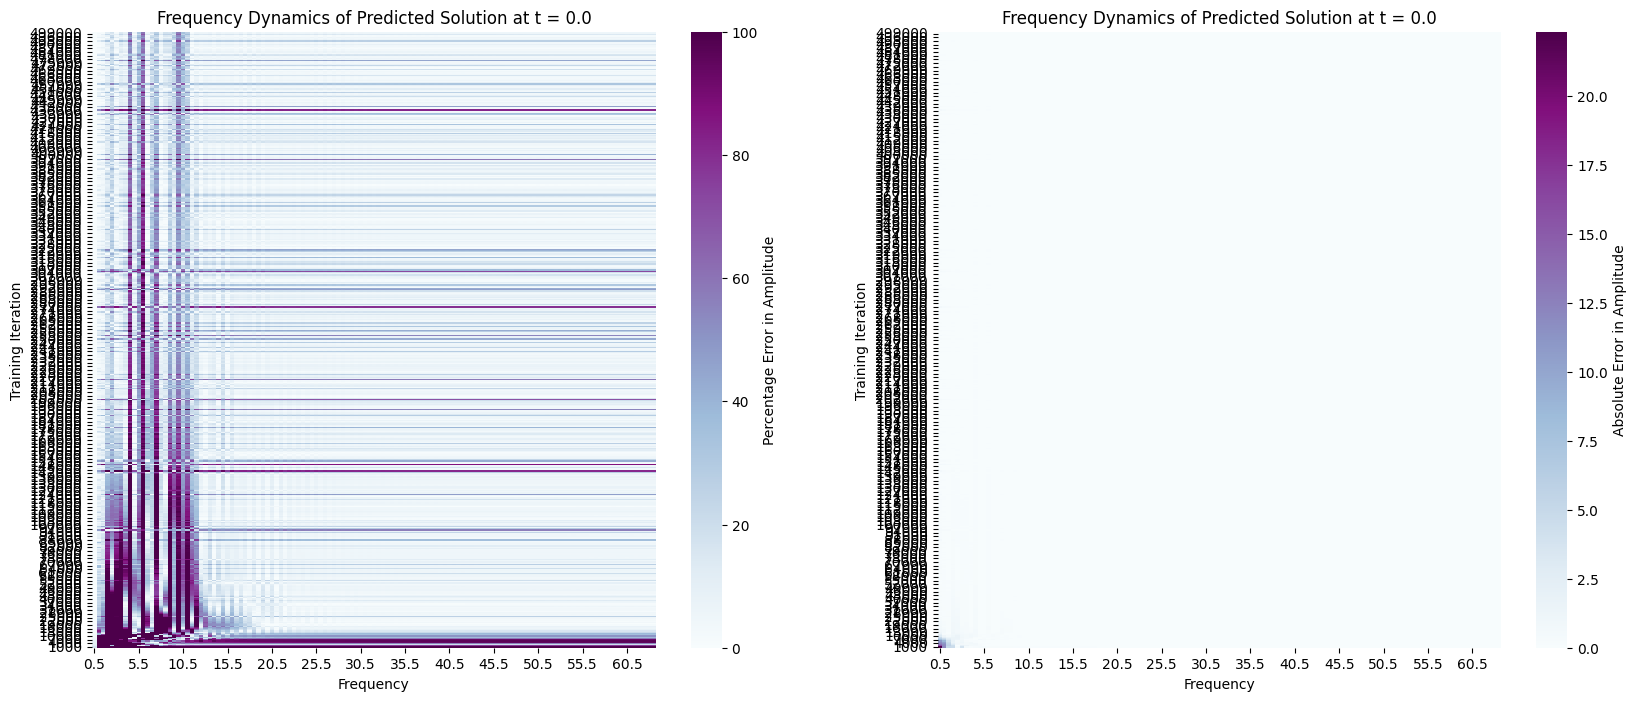

<ipython-input-11-476c5ac72057>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-11-476c5ac72057>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


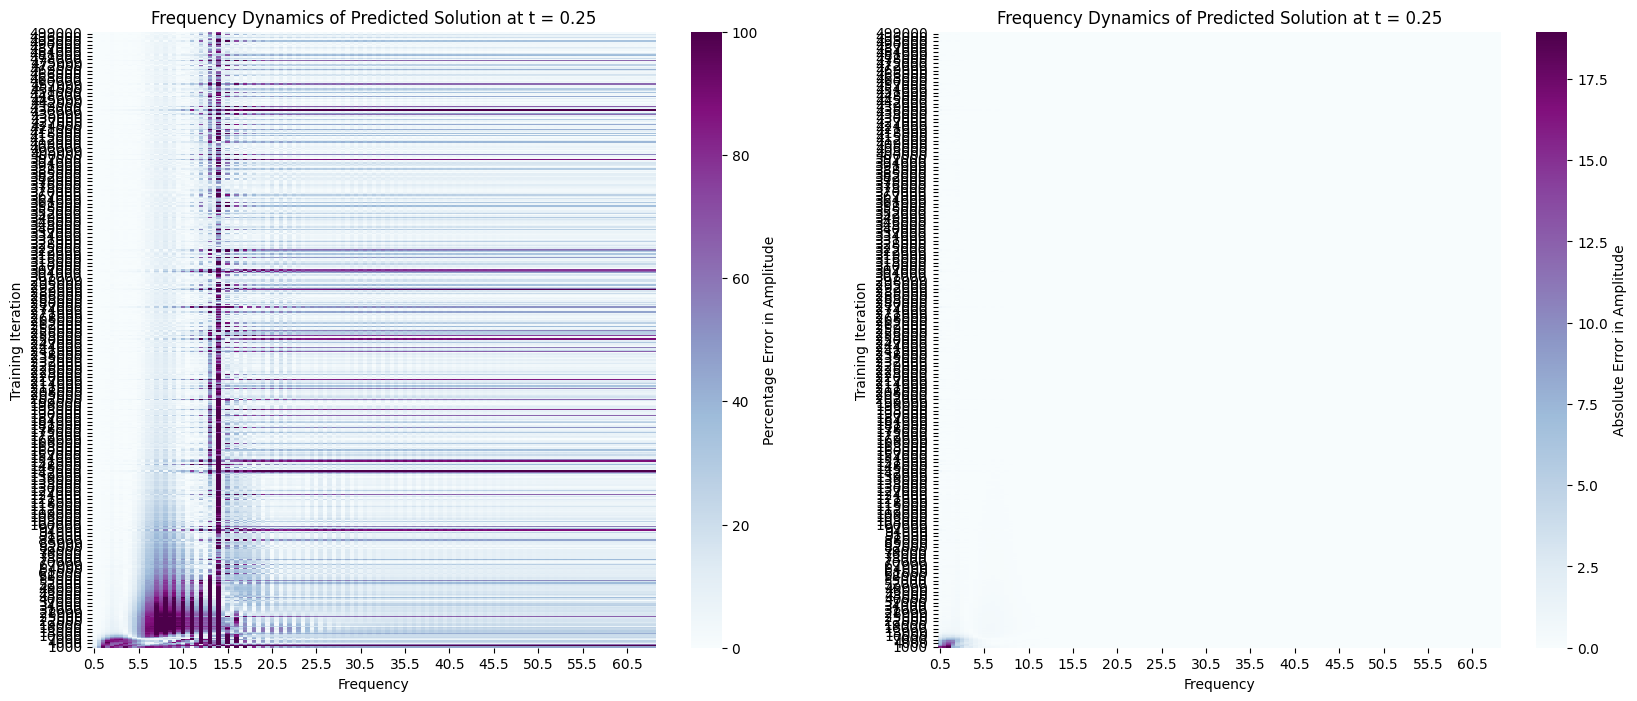

<ipython-input-11-476c5ac72057>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-11-476c5ac72057>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


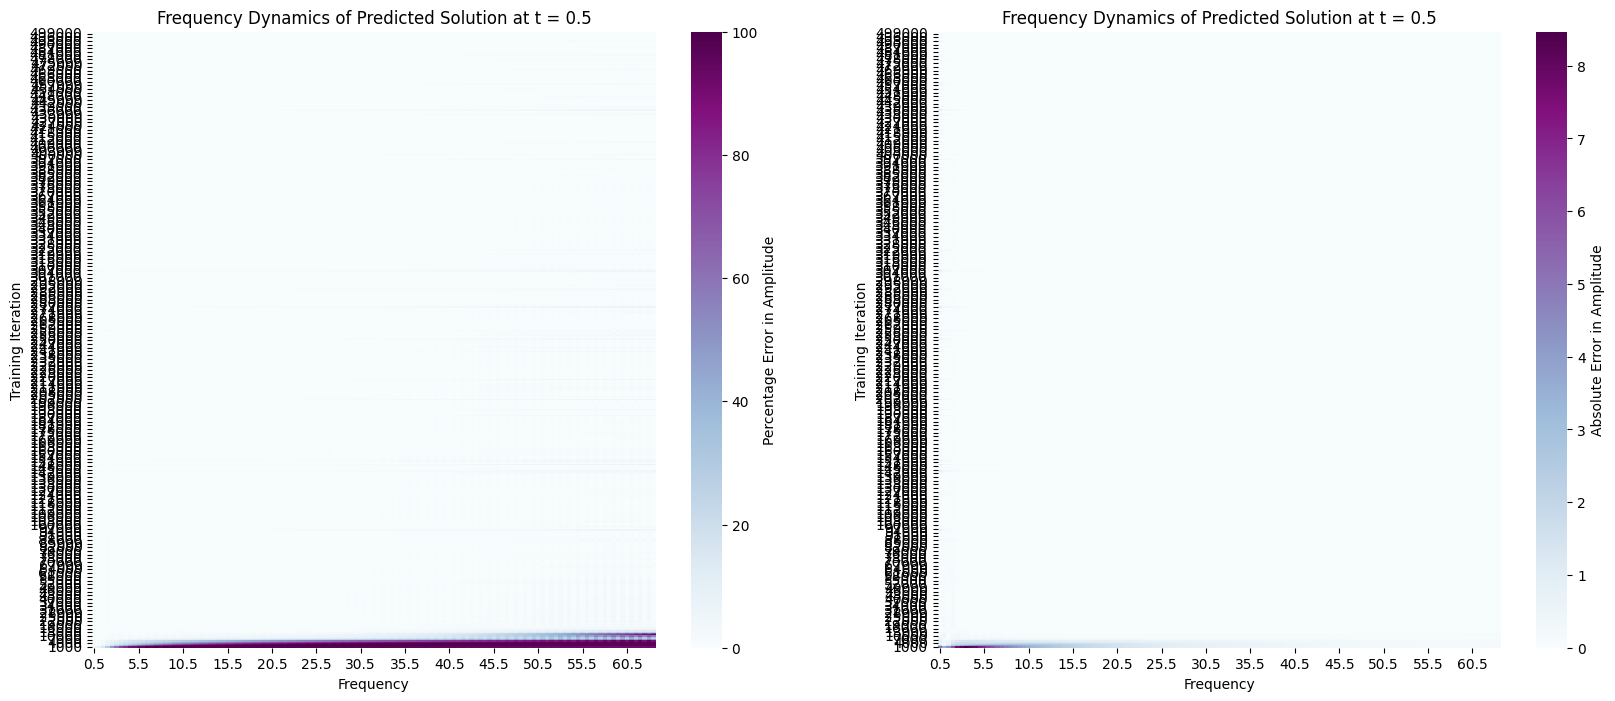

<ipython-input-11-476c5ac72057>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-11-476c5ac72057>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


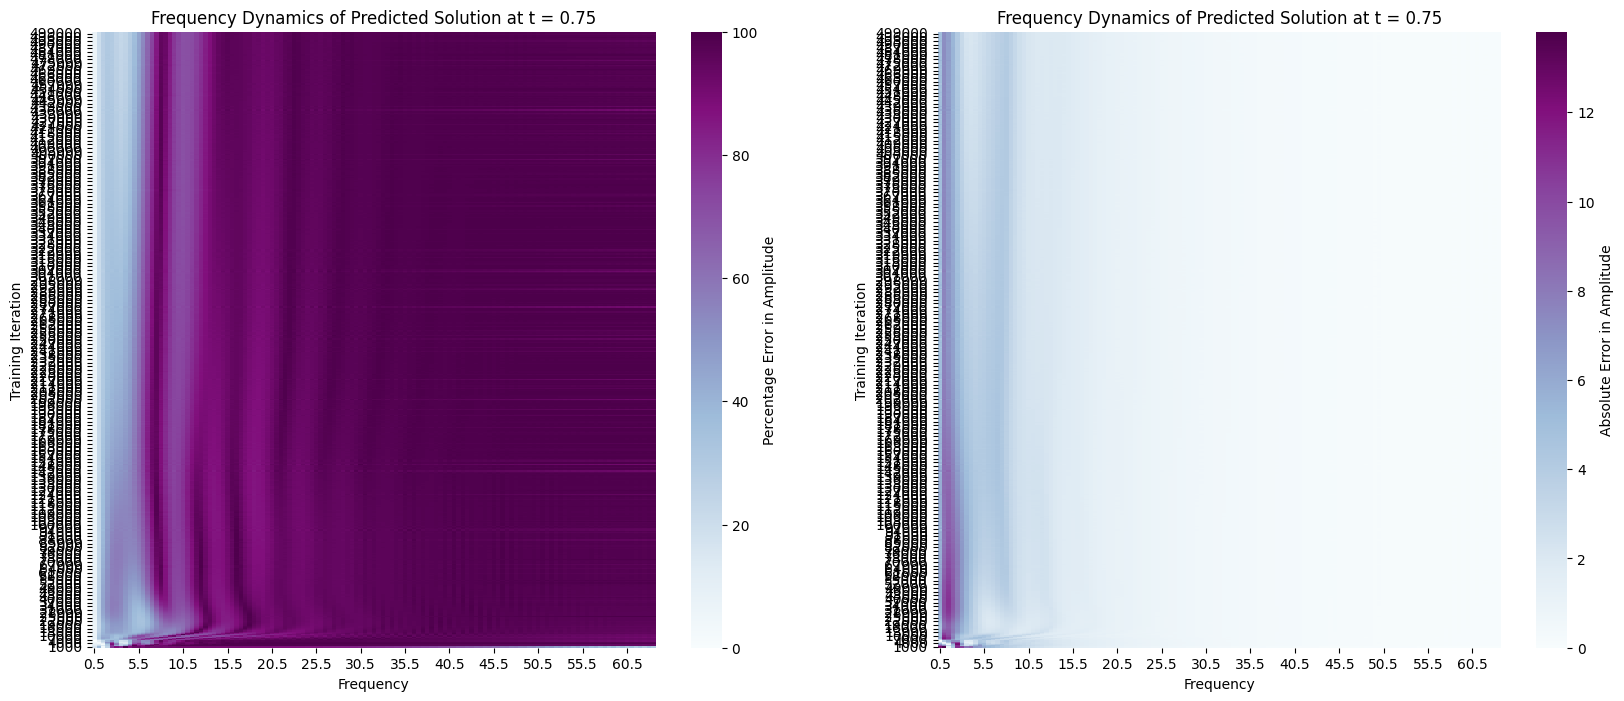

<ipython-input-11-476c5ac72057>:33: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pct_diffs = pct_diffs.pivot("iter", "freq", "value")
<ipython-input-11-476c5ac72057>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  abs_diffs = abs_diffs.pivot("iter", "freq", "value")


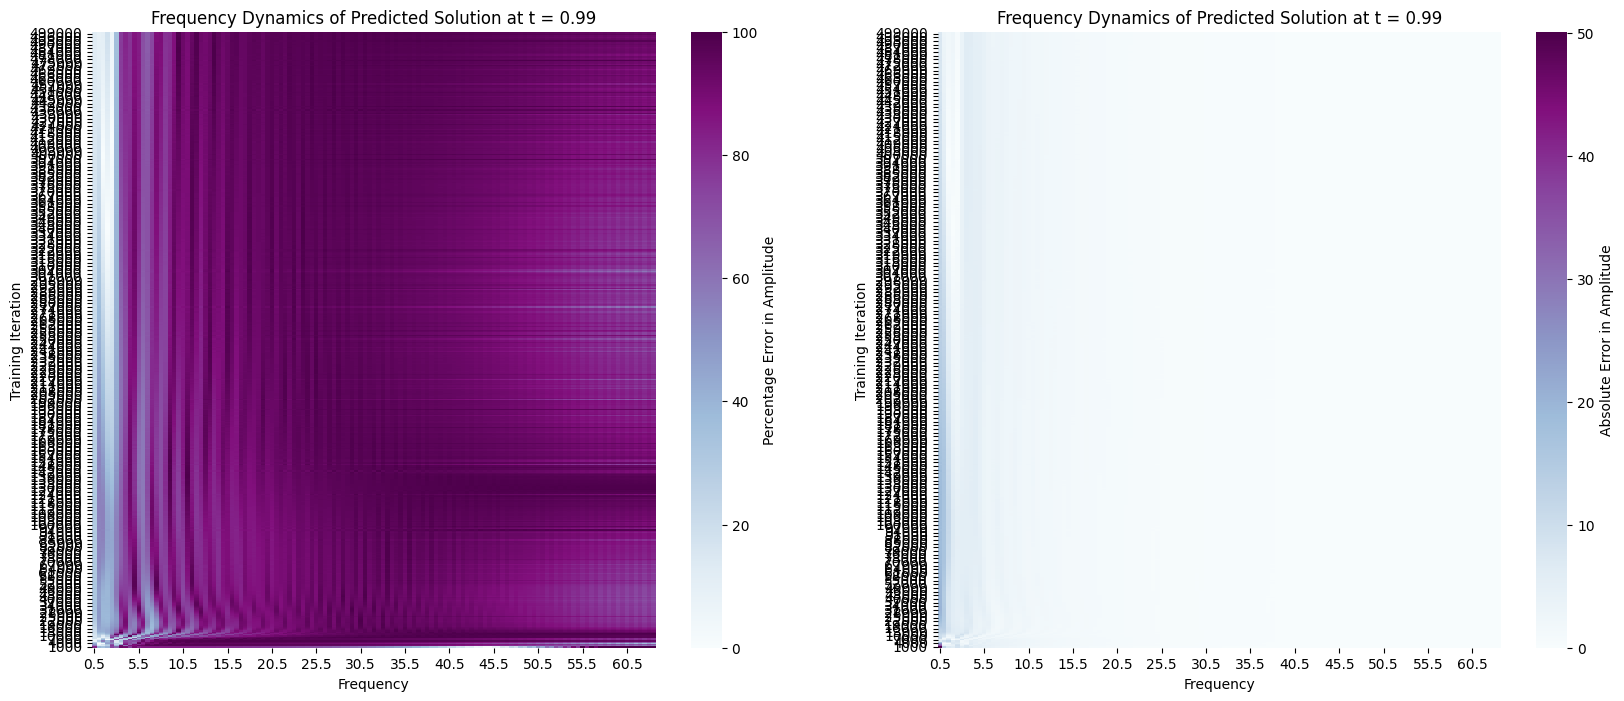

In [ ]:
plot_spectral_dynamics(all_preds, y_true, 0.00)
plot_spectral_dynamics(all_preds, y_true, 0.25)
plot_spectral_dynamics(all_preds, y_true, 0.50)
plot_spectral_dynamics(all_preds, y_true, 0.75)
plot_spectral_dynamics(all_preds, y_true, 0.99)

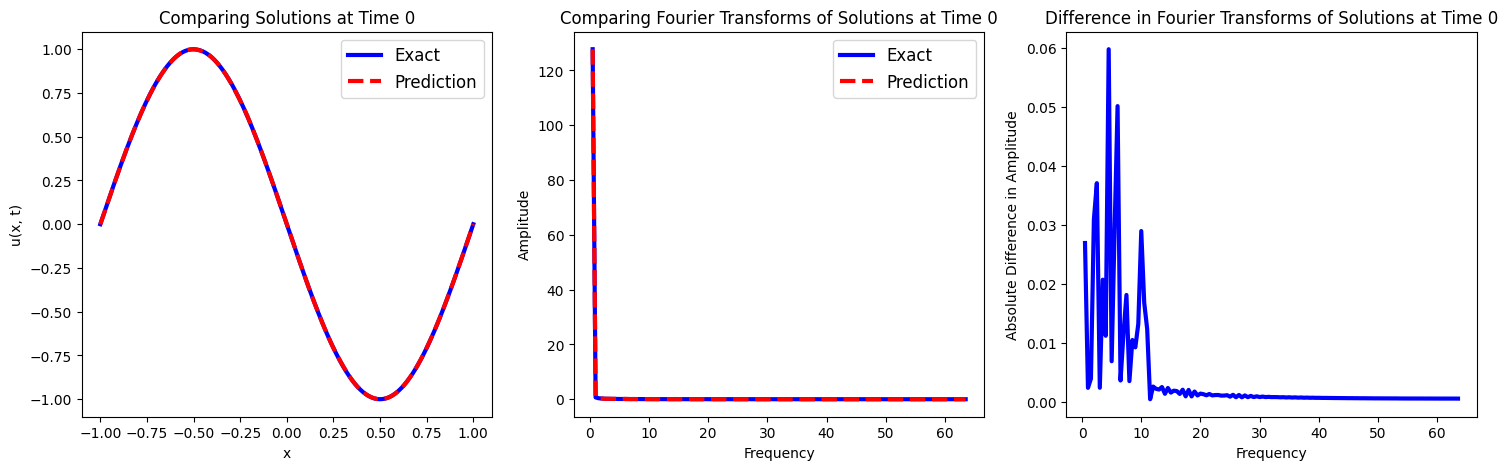

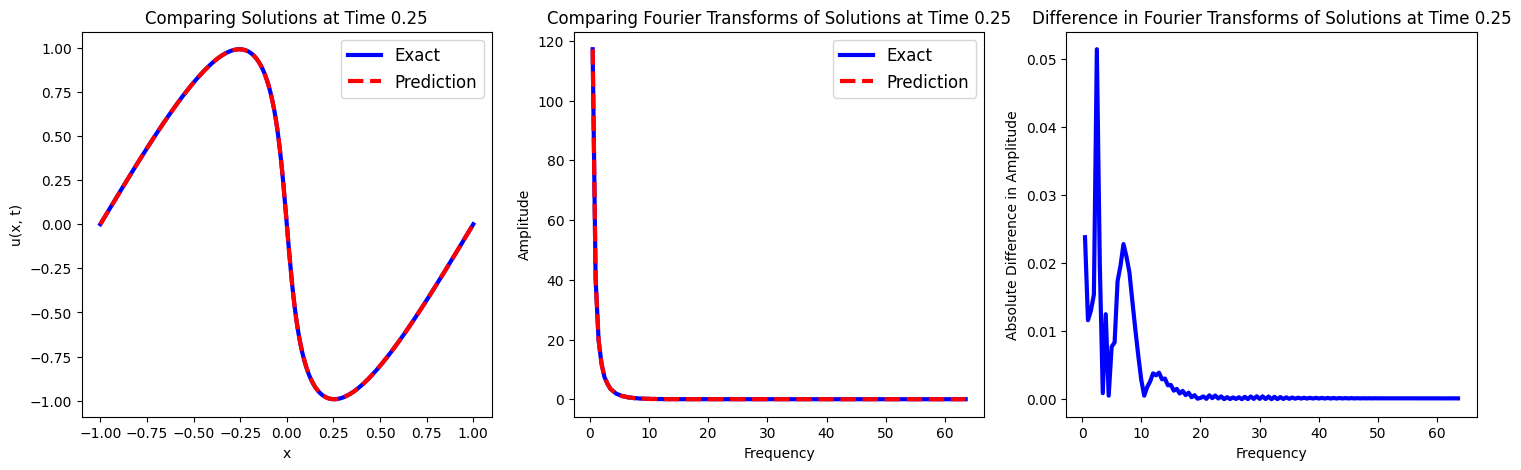

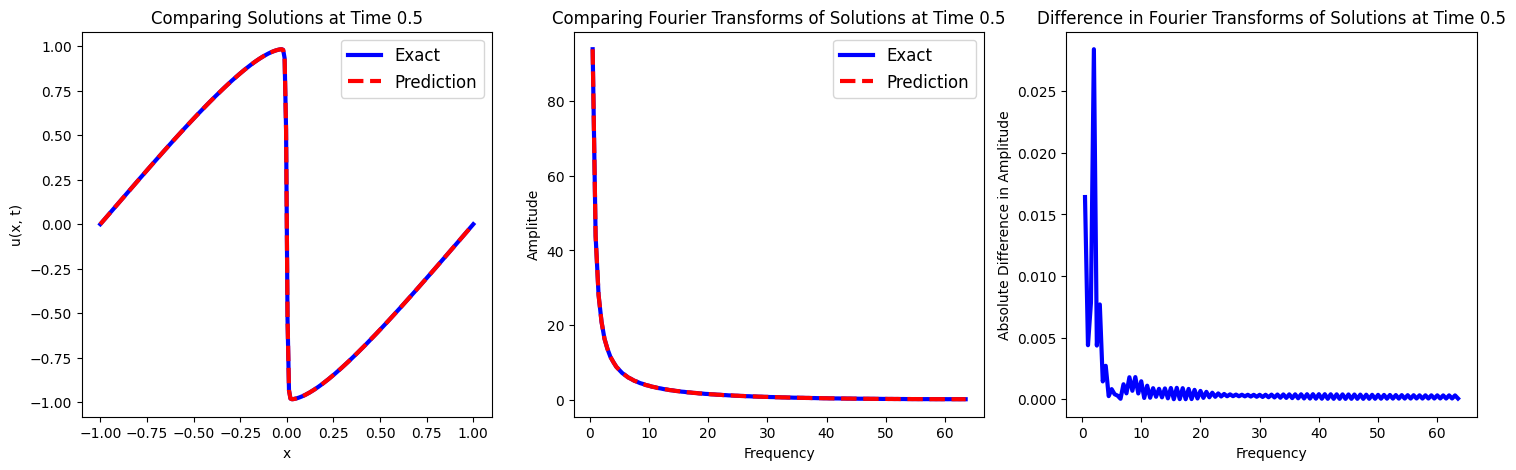

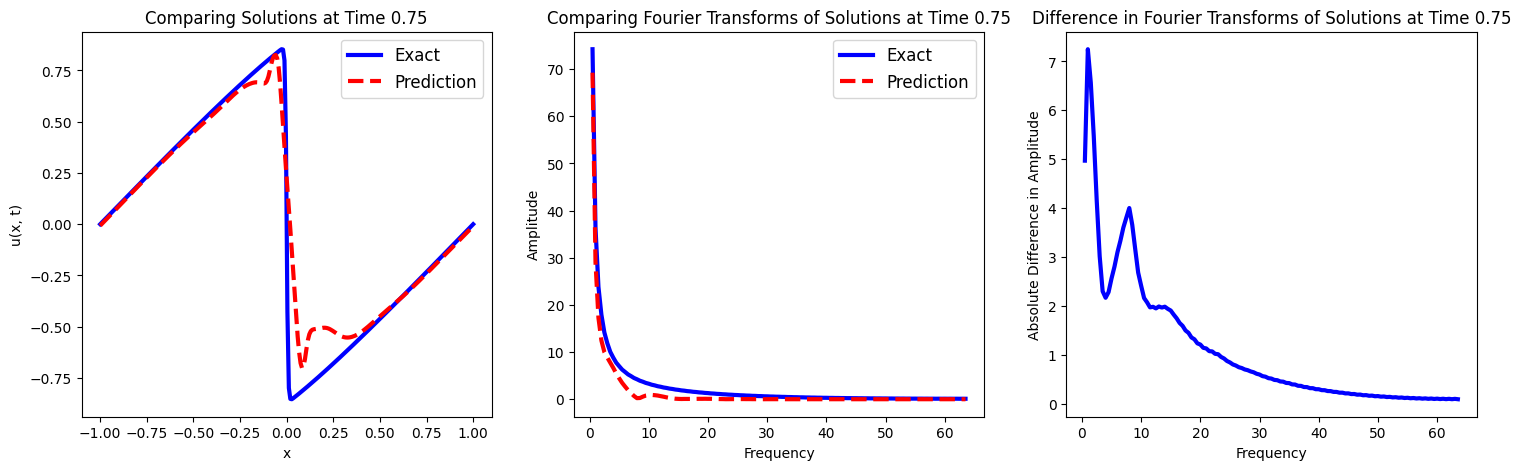

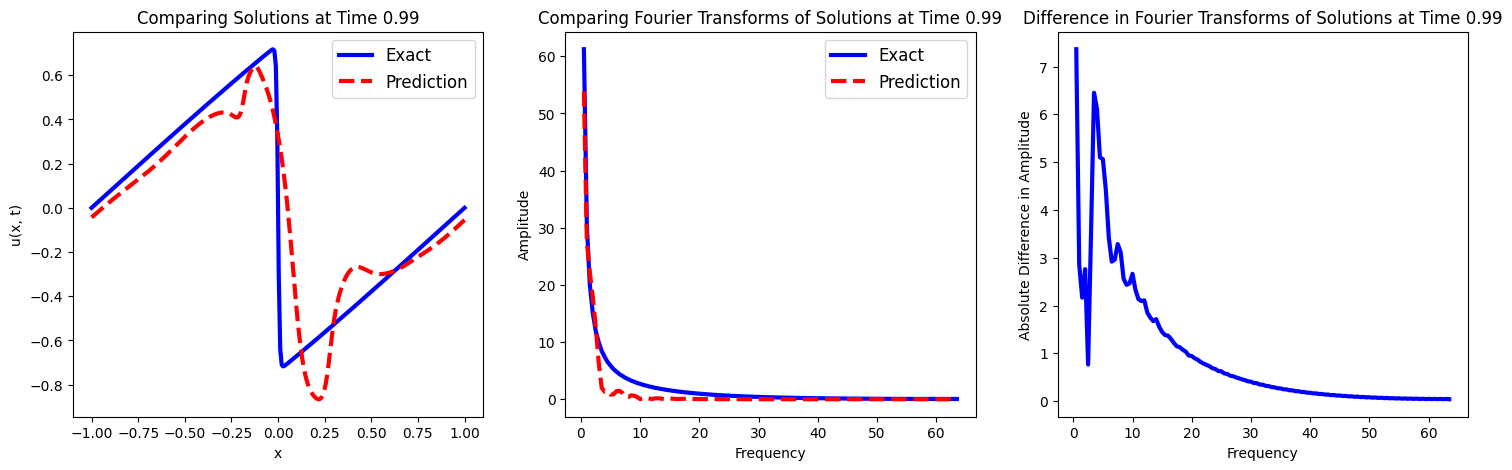

In [ ]:
compare_solutions(0, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.25, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.5, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.75, y_true, all_preds[500000], domain_len=2)
compare_solutions(0.99, y_true, all_preds[500000], domain_len=2)

<ipython-input-12-2ed401da69d3>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-12-2ed401da69d3>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


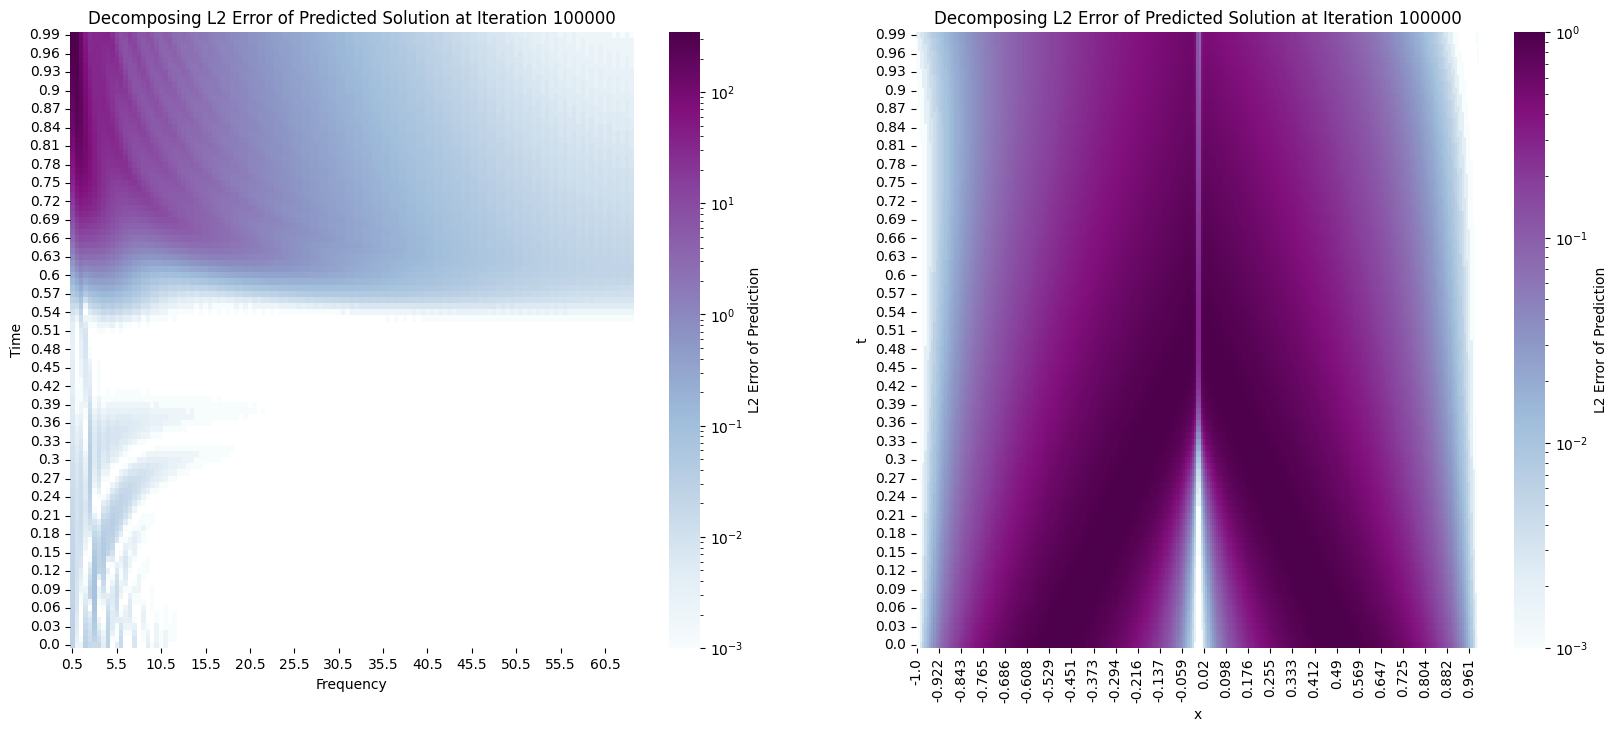

<ipython-input-12-2ed401da69d3>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-12-2ed401da69d3>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


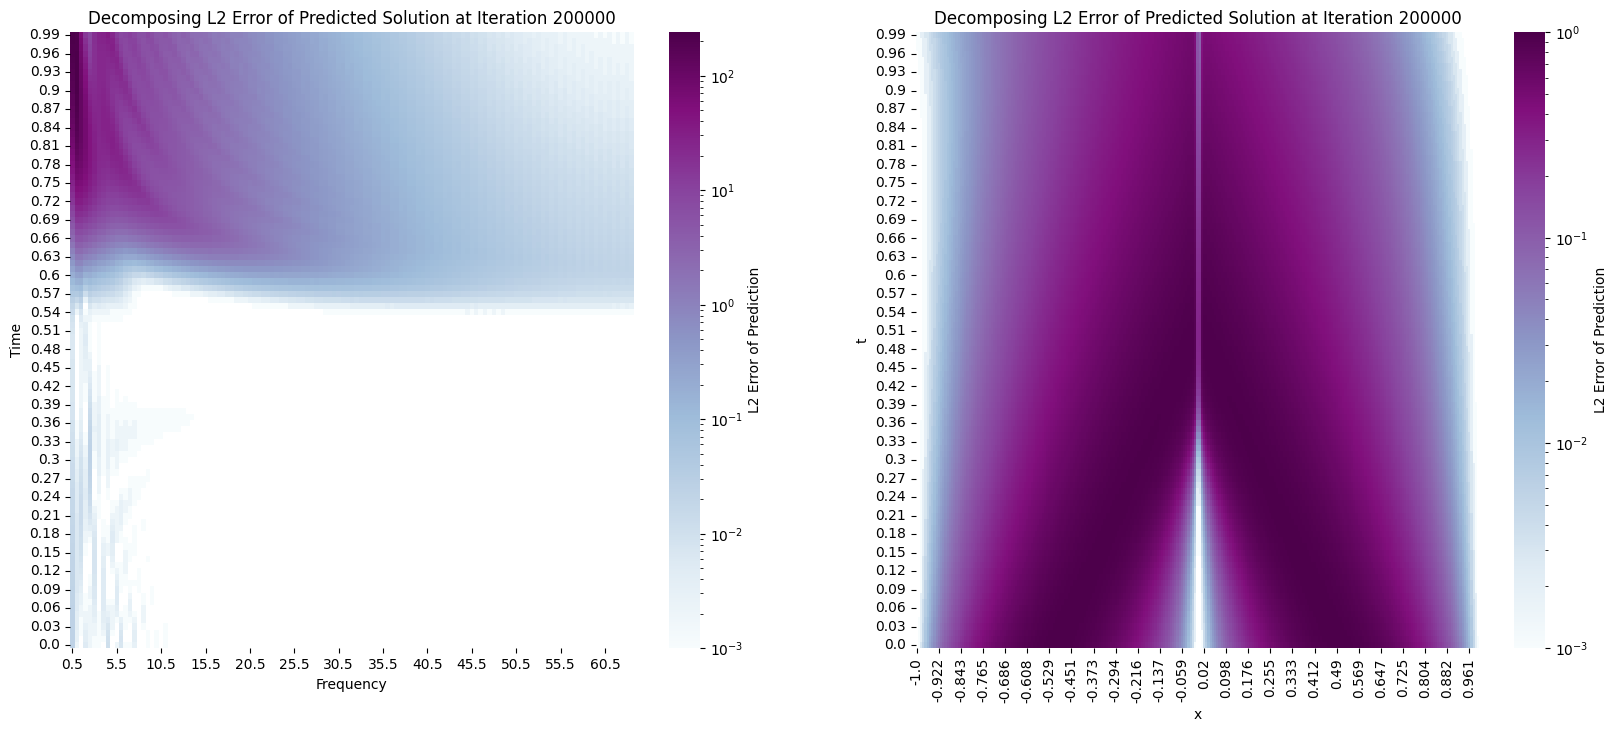

<ipython-input-12-2ed401da69d3>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-12-2ed401da69d3>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


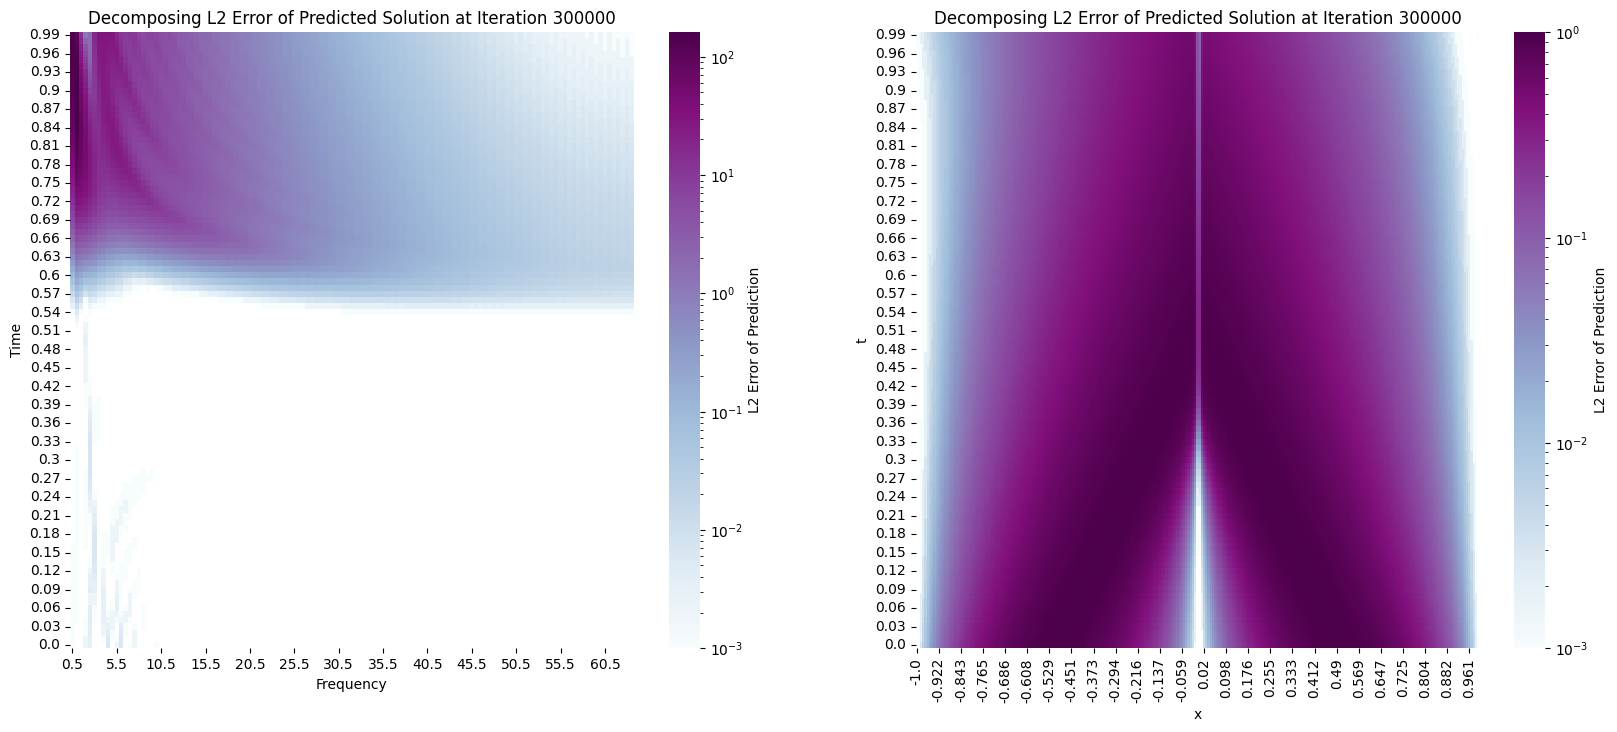

<ipython-input-12-2ed401da69d3>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-12-2ed401da69d3>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


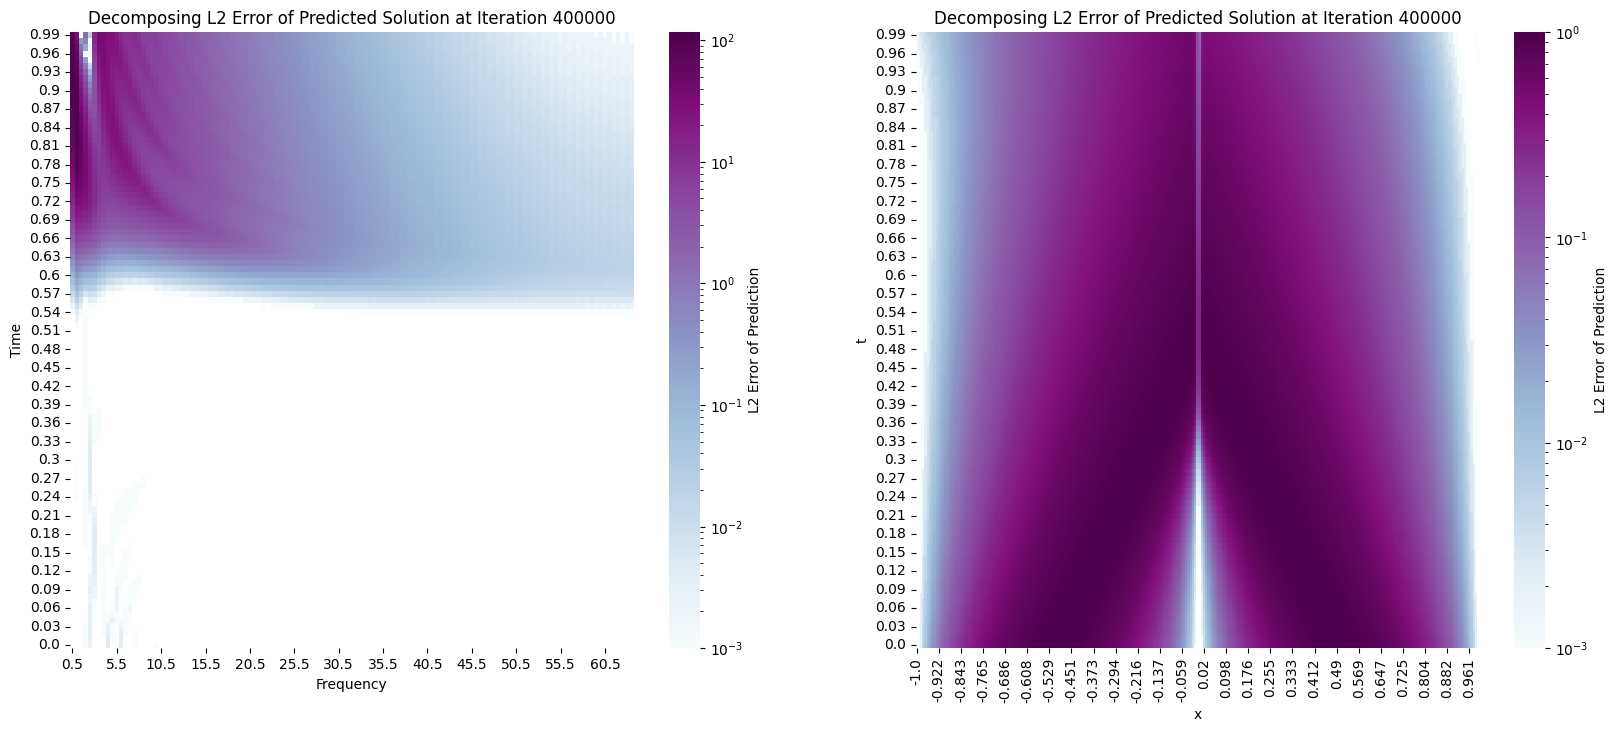

<ipython-input-12-2ed401da69d3>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  freq_errors = freq_errors.pivot("time", "freq", "value")
<ipython-input-12-2ed401da69d3>:41: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  l2_errors = l2_errors.pivot("time", "x", "value")


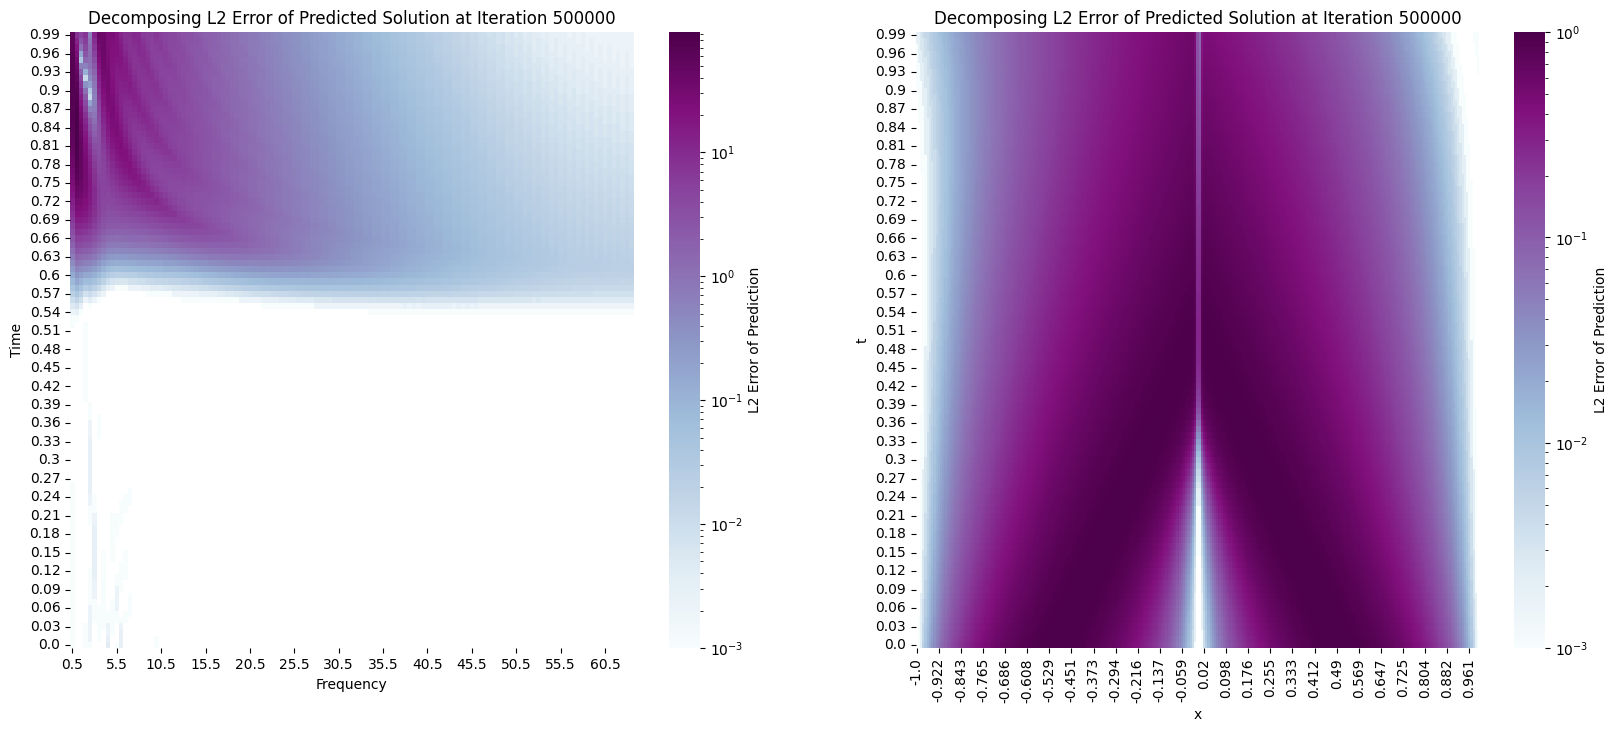

In [ ]:
plot_l2_errors(all_preds[100000], y_true, 100000, domain_len=2)
plot_l2_errors(all_preds[200000], y_true, 200000, domain_len=2)
plot_l2_errors(all_preds[300000], y_true, 300000, domain_len=2)
plot_l2_errors(all_preds[400000], y_true, 400000, domain_len=2)
plot_l2_errors(all_preds[500000], y_true, 500000, domain_len=2)

### Spectral Norms

In [ ]:
opt = Namespace()

# Data Generation
opt.N = 256
# Model parameters
opt.INP_DIM = 1
opt.OUT_DIM = 1
opt.WIDTH = 256
opt.DEPTH = 6
# Training
opt.CUDA = True
opt.NUM_ITER = 60000
opt.REC_FRQ = 100
opt.LR = 0.0003

#### Architecture

In [ ]:
def init_xavier(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)

def get_model(input_size, output_size, n_hidden=5, hidden_width=100, activation=nn.ReLU()):
    layers = nn.ModuleList()
    layer_dims = [input_size, *(n_hidden*[hidden_width])]
    for i, j in zip(layer_dims, layer_dims[1:]):
        layers.append(nn.Linear(i, j))
        layers.append(activation)
    layers.append(nn.Linear(layer_dims[-1], output_size))

    model = nn.Sequential(*layers)
    model.apply(init_xavier)
    return model

#### Burgers Equation

In [ ]:
def burgers1d_inviscid_func(model_preds, t, x):
    u_t = grad(outputs=model_preds, inputs=t, grad_outputs=torch.ones_like(model_preds), create_graph=True, retain_graph=True)[0]
    u_x = grad(outputs=model_preds, inputs=x, grad_outputs=torch.ones_like(model_preds), create_graph=True, retain_graph=True)[0]
    u_xx = grad(outputs=u_x, inputs=x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    return u_t + model_preds.squeeze() * u_x - (0.01 / np.pi) * u_xx 

def sample_domain(n=100, t_range=[0, 1]):
    sample_t = torch.zeros(size=(n,), device=device).uniform_(*t_range)
    sample_x = torch.zeros(size=(n,), device=device).uniform_(-1, 1)
    sample_t.requires_grad = True
    sample_x.requires_grad = True
    
    return sample_t, sample_x


def sample_dirichlet_boundary(n=100, ic_bc_ratio=0.8, t_range=[0, 1]):
    n_ic = int(n*ic_bc_ratio)
    n_bc = n - n_ic

    # u(t=0, x) = -sin(Pi*x)
    sample_ic_t = torch.zeros(size=(n_ic,), device=device)
    sample_ic_x = torch.zeros(size=(n_ic,), device=device).uniform_(-1, 1)
    sample_ic_input = torch.stack((sample_ic_t, sample_ic_x), dim=1)
    sample_ic_u = -torch.sin(np.pi * sample_ic_x)

    # u(t, x=+/-1) = 0
    sample_bc_t = torch.zeros(size=(n_bc,), device=device).uniform_(*t_range)
    sample_bc_x = torch.bernoulli(torch.ones(size=(n_bc,), device=device)*0.5) * 2 - 1 
    sample_bc_u = torch.zeros(size=(n_bc,), device=device)
    sample_bc_input = torch.stack((sample_bc_t, sample_bc_x), dim=1)

    return torch.vstack((sample_ic_input, sample_bc_input)), torch.cat((sample_ic_u, sample_bc_u)).unsqueeze(dim=1)


# import data for the true solution
def gen_testdata():
    data = np.load("Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

#### Spectral Bias

In [ ]:
def power_iteration(A, num_simulations=10):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    A = A.data
    b_k = A.new(A.shape[1], 1).normal_()
    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = A @ b_k
        # calculate the norm
        b_k1_norm = torch.norm(b_k1)
        # re normalize the vector
        b_k = b_k1 / b_k1_norm
    return ((b_k.t() @ A @ b_k) / b_k.t() @ b_k).squeeze().abs()
    # return torch.dot(torch.dot(b_k.t(), A), b_k) / torch.dot(b_k.t(), b_k)

def spectral_norm(model): 
    norms = []
    for layer in model: 
        if isinstance(layer, nn.Linear):
            if layer.in_features == layer.out_features: 
                norms.append(power_iteration(layer.weight).cpu().numpy())
            elif layer.in_features == 1 or layer.in_features == 2 or layer.out_features == 1: 
                norms.append(torch.norm(layer.weight.data).cpu().numpy())
    return norms

In [ ]:
def compute_spectra(opt, frames): 
    # Make array for heatmap
    dynamics = []
    xticks = []
    for iframe, frame in enumerate(frames): 
        # Compute fft of prediction
        frq, yfft = fft(opt, frame.prediction.squeeze())
        dynamics.append(yfft)
        xticks.append(frame.iter_num)
    return np.array(frq), np.array(dynamics), np.array(xticks)

def plot_spectral_dynamics(opt, all_frames):
    all_dynamics = []
    # Compute spectra for all frames
    for frames in all_frames: 
        frq, dynamics, xticks = compute_spectra(opt, frames)
        all_dynamics.append(dynamics)
    # Average dynamics over multiple frames
    # mean_dynamics.shape = (num_iterations, num_frequencies)
    mean_dynamics = np.array(all_dynamics).mean(0)
    # Select the frequencies which are present in the target spectrum
    freq_selected = mean_dynamics[:, np.sum(frq.reshape(-1, 1) == np.array(opt.K).reshape(1, -1), 
                                            axis=-1, dtype='bool')]
    # Normalize by the amplitude. Remember to account for the fact that the measured spectra 
    # are single-sided (positive freqs), so multiply by 2 accordingly
    norm_dynamics = 2 * freq_selected / np.array(opt.A).reshape(1, -1)
    # Plot heatmap
    plt.figure(figsize=(7, 6))
    # plt.title("Evolution of Frequency Spectrum (Increasing Amplitudes)")
    sns.heatmap(norm_dynamics[::-1], 
                xticklabels=opt.K, 
                yticklabels=[(frame.iter_num if frame.iter_num % 10000 == 0 else '') 
                             for _, frame in zip(range(norm_dynamics.shape[0]), frames)][::-1], 
                vmin=0., vmax=1., 
                cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, reverse=True, as_cmap=True))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Training Iteration")
    plt.show()

def plot_multiple_spectral_norms(all_frames):
    iter_nums = np.array([frame.iter_num for frame in all_frames[0]])
    norms = np.array([np.array(list(zip(*[frame.spectral_norms for frame in frames]))).squeeze() for frames in all_frames])
    means = norms.mean(0)
    stds = norms.std(0)
    plt.xlabel("Training Iteration")
    plt.ylabel("Spectral Norm of Layer Weights")
    for layer_num, (mean_curve, std_curve) in enumerate(zip(means, stds)): 
        p = plt.plot(iter_nums, mean_curve, label=f'Layer {layer_num + 1}')
        plt.fill_between(iter_nums, mean_curve + std_curve, mean_curve - std_curve, color=p[0].get_color(), alpha=0.15)
    plt.legend()
    plt.show()

In [ ]:
def subset_solution(x_val, y_val, x_subset, t_subset=(0, 1.0)):
  zipped_vals = list(zip(true_x, true_y))

  t_start, t_end = t_subset

  if x_subset:
    return [(x, y) for ([x, t], [y]) in zipped_vals if x == x_subset and t >= t_start and t <= t_end]
  else:
    return [(x, y) for ([x, t], [y]) in zipped_vals if t >= t_start and t <= t_end]

#### Train Model

In [ ]:
model = get_model(2, 1)
model.to(device)
optimizer = optim.Adam(model.parameters())
boundary_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()

val_t = torch.linspace(0, 1, 100, device=device)
val_x = torch.linspace(-1, 1, 200, device=device)
val_tx = torch.cartesian_prod(val_t, val_x)

In [ ]:
def train_model(): 
  model = get_model(2, 1)
  model.to(device)
  optimizer = optim.Adam(model.parameters())
  boundary_criterion = nn.MSELoss()
  domain_criterion = nn.MSELoss()

  val_t = torch.linspace(0, 1, 100, device=device)
  val_x = torch.linspace(-1, 1, 200, device=device)
  val_tx = torch.cartesian_prod(val_t, val_x)

  train_losses = []
  domain_losses = []
  boundary_losses = []
  frames = []

  for iter_num in tqdm.trange(15_000):
      # forward pass
      domain_t, domain_x = sample_domain(n=3_000)
      boundary_pts, boundary_y = sample_dirichlet_boundary(n=1_000)

      domain_preds = model(torch.stack((domain_t, domain_x), dim=1))
      boundary_preds = model(boundary_pts)

      # backward pass
      f = burgers1d_inviscid_func(domain_preds, domain_t, domain_x)
      boundary_loss = boundary_criterion(boundary_preds, boundary_y)
      domain_loss = domain_criterion(f, torch.zeros_like(f))
      loss = domain_loss + boundary_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if iter_num % 100 == 0: 
              frames.append(Namespace(iter_num=iter_num,
                                      loss=loss.item(), 
                                      spectral_norms=spectral_norm(model)))

      train_losses.append(loss.item())
      domain_losses.append(domain_loss.item())
      boundary_losses.append(boundary_loss.item())

  return frames

In [ ]:
model = get_model(2, 1)
model.to(device)
optimizer = optim.Adam(model.parameters())
boundary_criterion = nn.MSELoss()
domain_criterion = nn.MSELoss()

val_t = torch.linspace(0, 1, 100, device=device)
val_x = torch.linspace(-1, 1, 200, device=device)
val_tx = torch.cartesian_prod(val_t, val_x)

train_losses = []
domain_losses = []
boundary_losses = []
frames = []

for iter_num in tqdm.trange(15_000):
    # forward pass
    domain_t, domain_x = sample_domain(n=3_000, t_range=[0, 0.5])
    boundary_pts, boundary_y = sample_dirichlet_boundary(n=1_000, t_range=[0, 0.5])

    domain_preds = model(torch.stack((domain_t, domain_x), dim=1))
    boundary_preds = model(boundary_pts)

    # backward pass
    f = burgers1d_inviscid_func(domain_preds, domain_t, domain_x)
    boundary_loss = boundary_criterion(boundary_preds, boundary_y)
    domain_loss = domain_criterion(f, torch.zeros_like(f))
    loss = domain_loss + boundary_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter_num % 100 == 0: 
            frames.append(Namespace(iter_num=iter_num,
                                    loss=loss.item(), 
                                    spectral_norms=spectral_norm(model)))

    train_losses.append(loss.item())
    domain_losses.append(domain_loss.item())
    boundary_losses.append(boundary_loss.item())

100%|██████████| 15000/15000 [01:52<00:00, 133.05it/s]


In [ ]:
def get_model_predictions(ts, xs):
  inputs = torch.stack((torch.FloatTensor(ts), torch.FloatTensor(xs)), dim=1).to(device)
  with torch.no_grad():
    outputs = model(inputs)

  return outputs

In [ ]:
def predict_sol(t, num_points=256):
  xs = list(np.linspace(-1.0, 1.0, num_points))
  ts = [t for _ in range(num_points)]

  return xs, list(get_model_predictions(ts, xs).flatten().cpu().numpy())

#### Plots

In [ ]:
all_frames = []

for _ in range(10):
  frames = train_model()
  all_frames.append(frames)

100%|██████████| 15000/15000 [01:55<00:00, 129.79it/s]


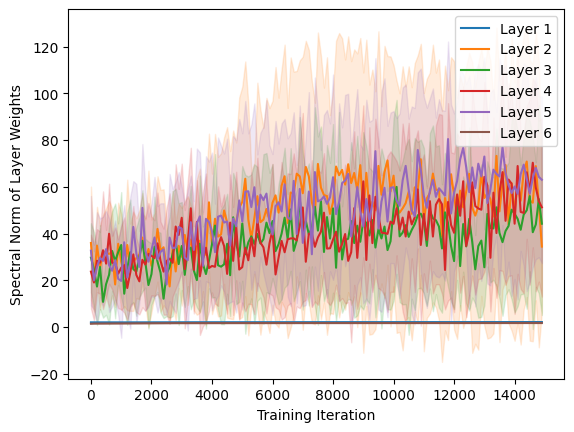

In [ ]:
plot_multiple_spectral_norms(all_frames)

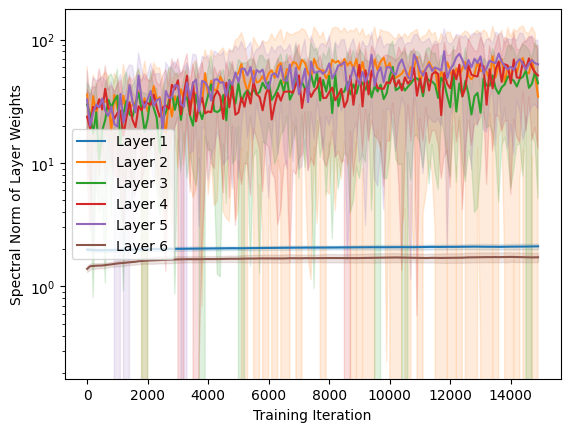

In [ ]:
plt.yscale('log')
plot_multiple_spectral_norms(all_frames)